In [59]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.signal import welch
from scipy.optimize import curve_fit

In [4]:
def get_psd(data, channel=1):
    fs = int(np.ceil(1 / (data[0, 1] - data[0, 0])))
    nperseg = fs / 10
    
    ff, pp = welch(data[channel], fs=fs, nperseg=nperseg)
    return ff, pp

In [33]:
def get_peak_area(data, channel=1, fdrive=20000):
    """Integrate to get the area under a driven peak"""
    ff, pp = get_psd(data, channel=channel)
    
    peak_idx = int(fdrive / 10)
    lb, ub = peak_idx-10, peak_idx+10
    
    all_idx = np.arange(lb, ub, 1)
    excluding_peak = np.logical_or(all_idx < (peak_idx-3), all_idx > (peak_idx+3))

    area_all = np.trapz(pp[all_idx], ff[all_idx]*2*np.pi)
    area_excluding_peak = np.trapz( pp[all_idx[excluding_peak]], ff[all_idx[excluding_peak]]*2*np.pi )

    # Excluding background contribution (which is very small anyway)
    # Take care of 2 pi normalization after numerical integration
    # because we integrated over omega here
    v2_drive = (area_all - area_excluding_peak) / (2 * np.pi)
    
    return v2_drive

In [87]:
def peak_func(x, amp, omega_0, gamma):
    """A Lorentzian line shape"""
    return amp * gamma / ( ( omega_0**2 - x**2)**2 + gamma**2 * x**2 )

def fit_peak(x, y, peak_func, p0=None):
    popt, pcov = curve_fit(peak_func, x, y, p0=p0)
    
    # Return central frequency and gamma
    return popt, x, peak_func(x, *popt)

In [34]:
charge = 2 * 1.6e-19  # Coulombs
efield = 250          # V/m when 1 V is applied

# Calibration factor converting <V^2> to <z^2>
# <z^2> = <V^2> / c_cal_square
c_cal_square = 80179930463.28465

In [35]:
ff_drive = np.arange(20000, 71000, 1000)

# Amplitude from zero in V
amp = np.full_like(ff_drive, 0.25, dtype=np.float64)
amp[np.logical_and(ff_drive > 37000, ff_drive < 43000)] = 0.05
amp[ff_drive > 51000] = 0.5

It takes a while to load all the data...

In [39]:
chisquare = np.zeros_like(ff_drive, dtype=np.float64)

for i, f in enumerate(ff_drive):
    f_khz      = int(f / 1000)
    amp_prefix = '0_5'
    if amp[i] == 0.05:
        amp_prefix = '0_1'
    elif amp[i] == 0.5:
        amp_prefix = '1'
        
    data_file = rf"D:\Experiment\Calibration\20230910\{f_khz}khz_{amp_prefix}vp2p.csv"
    data = np.genfromtxt(data_file, delimiter=',', skip_header=3).T

    v2_drive = get_peak_area(data, 1, f)
    x2_drive = v2_drive / c_cal_square
    
    f0 = charge * amp[i] * efield
    chisquare_drive = 2 * x2_drive / (f0**2)
    
    chisquare[i] = chisquare_drive

In [158]:
rho = 2200 # kg/m^3
r   = 167e-9 / 2
m   = rho * (4 * np.pi / 3) * r**3 

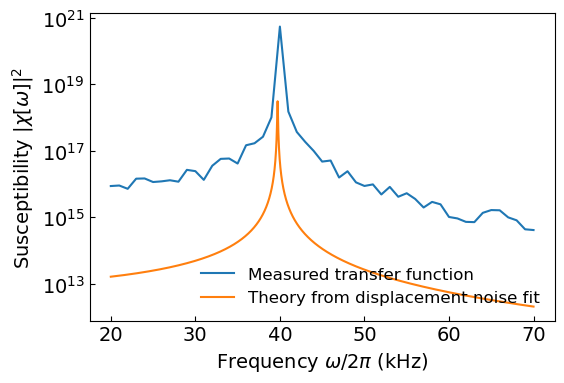

In [153]:
fig, ax = plt.subplots(figsize=(6, 4))

ax.plot(ff_drive/1000, chisquare, label='Measured transfer function')

# The amplitude is weird here...
# The factor of `gamma_low` is just to compensate the amplitude as defined in `peak_func()`
ax.plot(ff[lb:ub]/1000, peak_func(ff[lb:ub]*2*np.pi, 1/(m * m * gamma_low), omega0_low, gamma_low), label='Theory from displacement noise fit')

ax.set_xlabel(r'Frequency $\omega / 2 \pi$ (kHz)', fontsize=14)
ax.set_ylabel(r'Susceptibility $| \chi[\omega] |^2$', fontsize=14)
ax.legend(loc='lower right', frameon=False, fontsize=12)
ax.tick_params(axis='both', which='both', direction='in', labelsize=14)
ax.set_yscale('log')

In [47]:
# outfile = 'transfer_func_chisquare.csv'
# np.savetxt(outfile, np.asarray([ff_drive, chisquare]).T, delimiter=',', header='Frequency (Hz)   chi_square')

Low Pressure - Amplitude: 1126079.756710077, central frequency: 39725.95043545785 Hz, gamma/2pi: 66.91603083193236 Hz


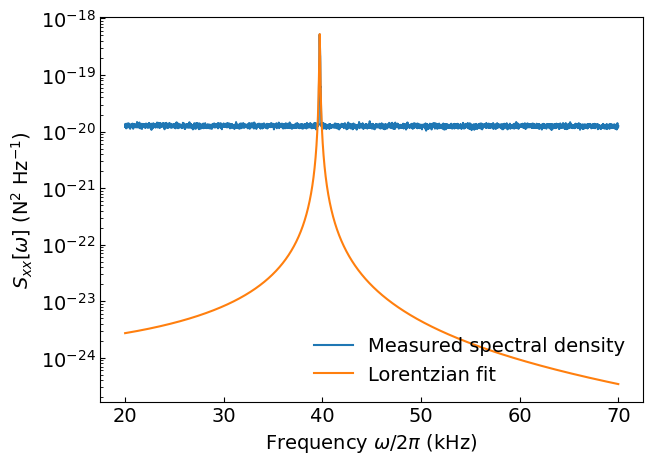

In [128]:
# data_file = r"D:\Experiment\Calibration\20230910\noefield.csv"
# data = np.genfromtxt(data_file, delimiter=',', skip_header=3).T

# ff, pp = get_psd(data)

lb, ub = 2000, 7001

fig, ax = plt.subplots(figsize=(7, 5))
ax.plot(ff[lb:ub]/1000, pp[lb:ub]/c_cal_square, label='Measured spectral density')

# Fit with a Lorentzian and plot
popt, omega_fit, p_fit = fit_peak(ff[lb:ub]*2*np.pi, pp[lb:ub], peak_func, p0=[1e6, 40000*2*np.pi, 400])
ax.plot(omega_fit/(2*np.pi*1000), p_fit/c_cal_square, label='Lorentzian fit')

amp_low, omega0_low, gamma_low = popt[0], popt[1], popt[2]
print(f'Low Pressure - Amplitude: {amp_low}, central frequency: {omega0_low/(2*np.pi)} Hz, gamma/2pi: {gamma_low / (2 * np.pi)} Hz')

ax.set_yscale('log')
ax.set_xlabel(r'Frequency $\omega / 2 \pi$ (kHz)', fontsize=14)
ax.set_ylabel(r'$S_{xx}[\omega]$ (N$^2$ Hz$^{-1}$)', fontsize=14)
ax.legend(loc='lower right', frameon=False, fontsize=14)
ax.tick_params(axis='both', which='both', direction='in', labelsize=14)

In [130]:
amp_low * gamma_low / c_cal_square

0.005904913186090459

In [133]:
2 * 1.38e-23 * 0.5 * gamma_low / m

0.001081479796830475

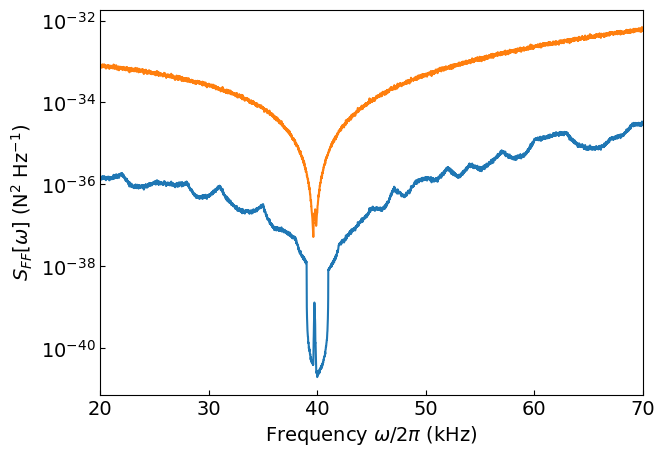

In [151]:
fig, ax = plt.subplots(figsize=(7, 5))

lb, ub = 2000, 7001
sxx = pp / c_cal_square
sff = sxx[lb:ub] / np.interp(ff[lb:ub], ff_drive, chisquare)
sff_theory = sxx[lb:ub] / peak_func(ff[lb:ub]*2*np.pi, 1/(m * m * gamma_low), omega0_low, gamma_low)

ax.plot(ff[lb:ub] / 1000, sff)
ax.plot(ff[lb:ub] / 1000, sff_theory)

ax.set_xlim(20, 70)
# ax.set_ylim(1e-41, 1e-34)
ax.set_yscale('log')
ax.set_xlabel(r'Frequency $\omega / 2 \pi$ (kHz)', fontsize=14)
ax.set_ylabel(r'$S_{FF}[\omega]$ (N$^2$ Hz$^{-1}$)', fontsize=14)
ax.tick_params(axis='both', which='both', direction='in', labelsize=14)

In [132]:
4 * np.pi * gamma_low * 0.5 * 1.38e-23

3.6455998332605347e-20